# Position control

Text(0, 0.5, 'Phase (degree)')

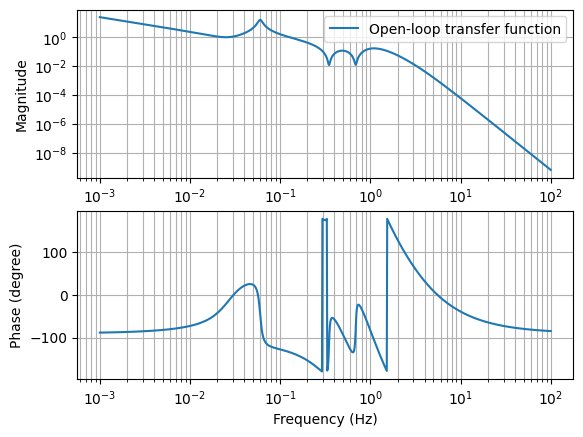

In [1]:
import control
import numpy as np
import matplotlib.pyplot as plt

import kontrol


# Load the transfer function
plant = kontrol.load_transfer_function("../system_modeling/transfer_function_x1_without_guess.pkl")

# Get a controller. regulator_type="PID" for PID controller.
# The I component gives the system the ability to trace a setpoint with 0 error.
# The P component speeds up the control.
controller = kontrol.regulator.oscillator.pid(plant, regulator_type="PID")

# We don't need to damp the high frequency modes.
# Get some notch filters
# the notch_peaks_above=0.1 means we'll notch all peaks above 0.1 Hz.
notches = kontrol.regulator.post_filter.post_notch(plant, regulator=controller, notch_peaks_above=0.1)
# ^this returns a list of notch filters.
notches = np.prod(notches) # To get a transfer function, we take the product of the notches.

# Get a low-pass filter.
# This lower the cut-off frequency of the low-pass filter until
# a specified phase margin is attained (defaults to 45 degrees.)
# Use the phase_margin option to override this.
low_pass = kontrol.regulator.post_filter.post_low_pass(plant, regulator=controller, post_filter=notches, order=4)

# Final filter.
controller *= low_pass*notches

# Inspect the open-loop transfer function
oltf = controller*plant

f = np.logspace(-3, 2, 1024)

plt.subplot(211)
plt.loglog(f, abs((oltf)(1j*2*np.pi*f)), label="Open-loop transfer function")
plt.legend(loc=0)
plt.grid(which="both")
plt.ylabel("Magnitude")

plt.subplot(212)
plt.semilogx(f, 180/np.pi*np.angle(oltf(1j*2*np.pi*f)))
# plt.legend(loc=0)
plt.grid(which="both")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Phase (degree)")

In [2]:
# ^This system has a UGF of around 0.128 Hz with a phase margin of about 45 degrees.
# Let's look at the open-loop and closed-loop performance against a step response, i.e. setpoint=1 at t=0.
t = np.linspace(0, 128, 1024)
_, y_open = control.step_response(plant, T=t)
_, y_close = control.step_response(oltf/(1+oltf), T=t)

Text(0.5, 0, 'Time (s)')

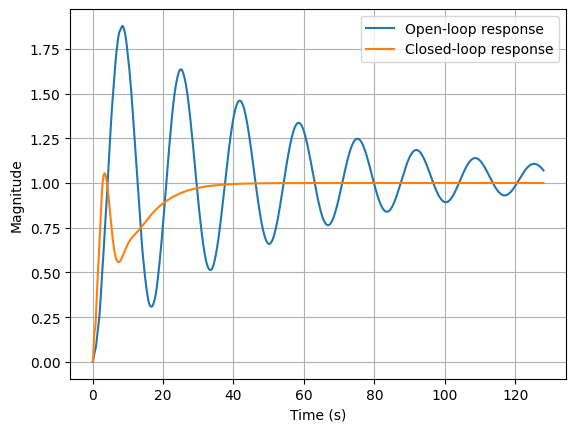

In [3]:
plt.plot(t, y_open, label="Open-loop response")
plt.plot(t, y_close, label="Closed-loop response")
plt.legend(loc=0)
plt.grid(which="both")
plt.ylabel("Magnitude")
plt.xlabel("Time (s)")
# Positon controlled

In [4]:
# Let's export the Foton string so we can install it into the digital system
controller = kontrol.TransferFunction(controller)
controller.foton(root_location="n")

'zpk([0.012454+i*0.024317;0.012454+i*-0.024317;0.012652+i*0.499616;0.012652+i*-0.499616;0.025355+i*0.999705;0.025355+i*-0.999705],[-0;0.249888+i*0.432819;0.249888+i*-0.432819;0.500013+i*0.866048;0.500013+i*-0.866048;1.887186+i*0.000255;1.887186+i*-0.000255;1.887697+i*0.000256;1.887697+i*-0.000256],0.024269,"n")'